In [19]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


## Used Bayesian inference to infer the parameters of a (linearised) gLV model

The generalized Lotka-Volterra equation takes the form

$$ \frac{dX_i}{dt} = \mu_i X_i + X_i M_{ij} X_j + X_i \epsilon_{il} u_l $$

where:
-   $X_i$ is the concentration of a species
-   $\mu_i$ is its specific growth rate
-   $M_{ij}$ is the effect of the interaction of species $i$ on species $j$
-   $\epsilon_{il}$ is the susceptibility to the time-dependent perturbation $u_l$

### Bayesian inference with no shrinkage    

X shape: (99, 6)
F shape: (99, 5)
Number of species: 5
AdvancedSetSubtensor.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 87 seconds.
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in sca

                 mean     sd  r_hat
mu_hat[0, 0]    1.149  0.459    1.0
mu_hat[0, 1]    0.963  0.448    1.0
mu_hat[0, 2]    1.337  0.459    1.0
mu_hat[0, 3]    0.992  0.445    1.0
mu_hat[0, 4]    1.199  0.089    1.0
M_ii_hat[0]    -0.080  0.056    1.0
M_ii_hat[1]    -0.081  0.063    1.0
M_ii_hat[2]    -0.081  0.060    1.0
M_ii_hat[3]    -0.078  0.062    1.0
M_ii_hat[4]    -0.225  0.016    1.0
M_ij_hat[0, 0] -0.111  0.055    1.0
M_ij_hat[0, 1] -0.030  0.058    1.0
M_ij_hat[0, 2]  0.097  0.055    1.0
M_ij_hat[0, 3]  0.014  0.054    1.0
M_ij_hat[1, 0] -0.022  0.036    1.0
M_ij_hat[1, 1] -0.108  0.038    1.0
M_ij_hat[1, 2]  0.043  0.037    1.0
M_ij_hat[1, 3]  0.018  0.037    1.0
M_ij_hat[2, 0]  0.048  0.052    1.0
M_ij_hat[2, 1]  0.009  0.054    1.0
M_ij_hat[2, 2] -0.203  0.052    1.0
M_ij_hat[2, 3] -0.014  0.051    1.0
M_ij_hat[3, 0]  0.016  0.023    1.0
M_ij_hat[3, 1]  0.056  0.025    1.0
M_ij_hat[3, 2] -0.030  0.024    1.0
M_ij_hat[3, 3] -0.021  0.024    1.0
M_ij_hat[4, 0]  0.001  0.037

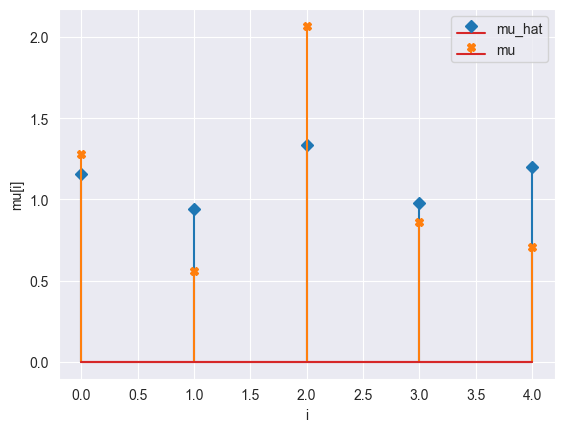

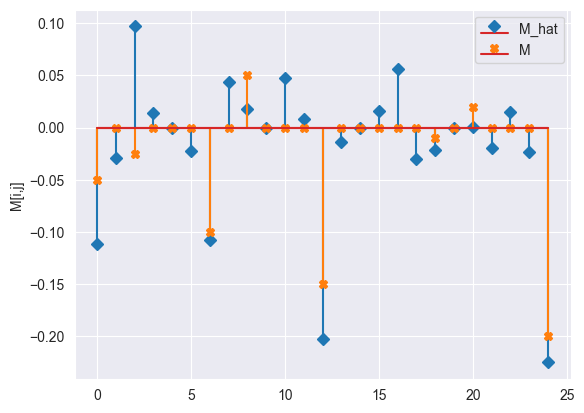

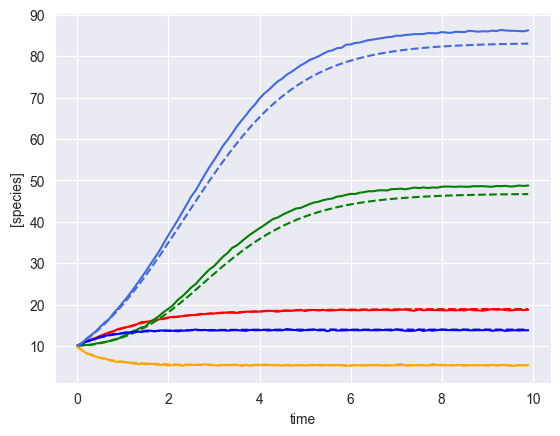

In [20]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 1
data = pd.read_csv("data-s5-r1.csv")
times = data.iloc[:, 0].values

yobs = data.iloc[:, 1:6].values

X, F = linearize_time_course_16S(yobs, times)

# Define priors
prior_mu_mean = 1.0 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()



summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)


In [22]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 3
data = pd.read_csv("data-s5-r3.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])


X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)



for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])
 
init_species = ryobs[timecourse_idx,0,:]  


X shape: (297, 6)
F shape: (297, 5)
Number of species: 5
AdvancedSetSubtensor.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in sca

mu_hat/mu:
[1.37900766 0.75427306 1.75976054 0.97201393 0.80485764]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.06 -0.    0.   -0.    0.  ]
 [ 0.   -0.09  0.    0.    0.  ]
 [-0.03 -0.01 -0.13 -0.01  0.  ]
 [-0.    0.04  0.   -0.01  0.  ]
 [ 0.    0.01  0.    0.   -0.15]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.37900766, 0.75427306, 1.75976054, 0.97201393, 0.80485764]), 'M': array([[-5.53447088e-02,  2.48087450e-03, -2.53992124e-02,
        -1.47318250e-03,  2.36219617e-03],
       [-1.51715003e-03, -9.01051536e-02, -1.39384006e-02,
         4.42238774e-02,  6.35337455e-03],
       [ 1.07203887e-03,  1.09040572e-04, -1.30364593e-01,
         1.63121496e-04,  9.23460262e-04],
       [-2.43800147e-03,  6.11157476e-04, -5.21396

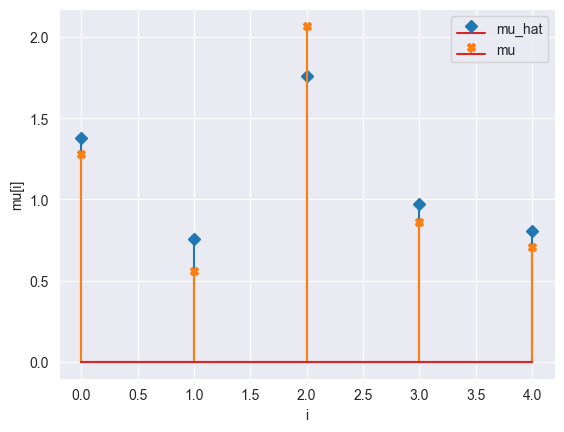

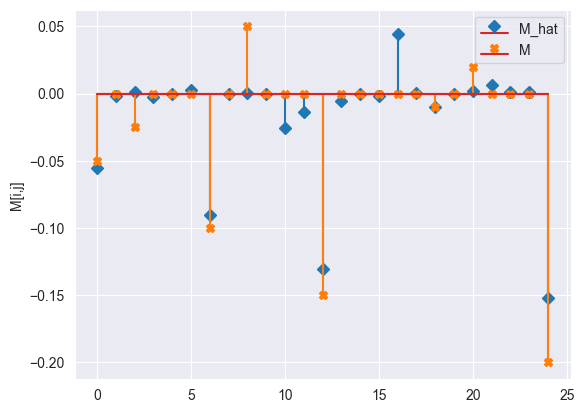

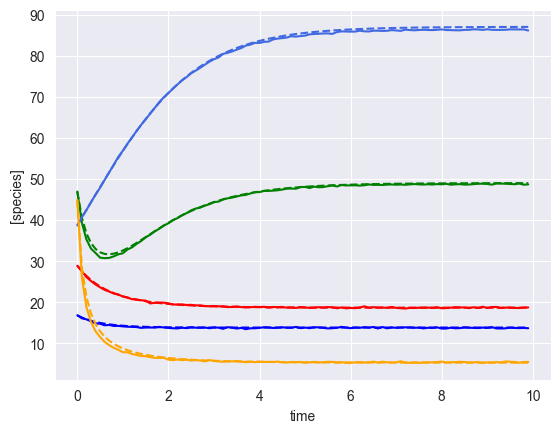

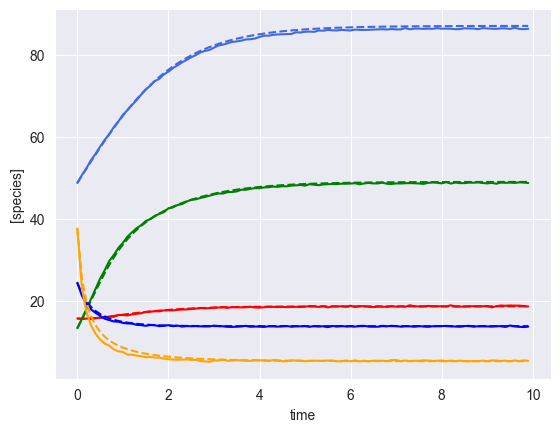

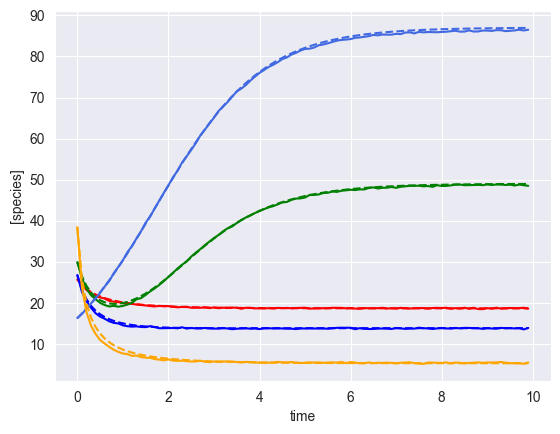

In [23]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 3
data = pd.read_csv("data-s5-r3.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])

X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])


# Define priors
prior_mu_mean = [1.0] 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
#print(summary[["mean", "sd", "r_hat"]])

# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

compare_params(mu=(mu, mu_h), M=(M, M_h))

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)

# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:])
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)



### Bayesian inference with shrinkage: Horseshoe prior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 37 seconds.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samp

                 mean     sd  r_hat
mu_hat[0, 0]    1.045  0.195   1.00
mu_hat[0, 1]    0.569  0.110   1.01
mu_hat[0, 2]    1.762  0.129   1.01
mu_hat[0, 3]    0.846  0.101   1.00
mu_hat[0, 4]    0.805  0.012   1.00
M_ii_hat[0]    -0.079  0.061   1.00
M_ii_hat[1]    -0.080  0.060   1.01
M_ii_hat[2]    -0.080  0.060   1.00
M_ii_hat[3]    -0.080  0.063   1.00
M_ii_hat[4]    -0.152  0.002   1.00
M_ij_hat[0, 0] -0.048  0.006   1.00
M_ij_hat[0, 1]  0.000  0.004   1.01
M_ij_hat[0, 2]  0.000  0.003   1.01
M_ij_hat[0, 3]  0.000  0.003   1.01
M_ij_hat[1, 0]  0.000  0.002   1.00
M_ij_hat[1, 1] -0.089  0.003   1.01
M_ij_hat[1, 2]  0.000  0.001   1.01
M_ij_hat[1, 3] -0.000  0.002   1.00
M_ij_hat[2, 0] -0.012  0.009   1.00
M_ij_hat[2, 1] -0.001  0.004   1.01
M_ij_hat[2, 2] -0.129  0.007   1.01
M_ij_hat[2, 3] -0.001  0.004   1.01
M_ij_hat[3, 0]  0.000  0.001   1.01
M_ij_hat[3, 1]  0.044  0.002   1.01
M_ij_hat[3, 2]  0.000  0.001   1.01
M_ij_hat[3, 3] -0.010  0.001   1.01
M_ij_hat[4, 0] -0.001  0.002

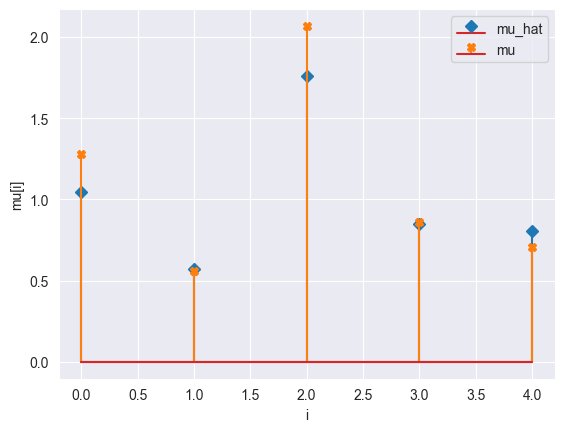

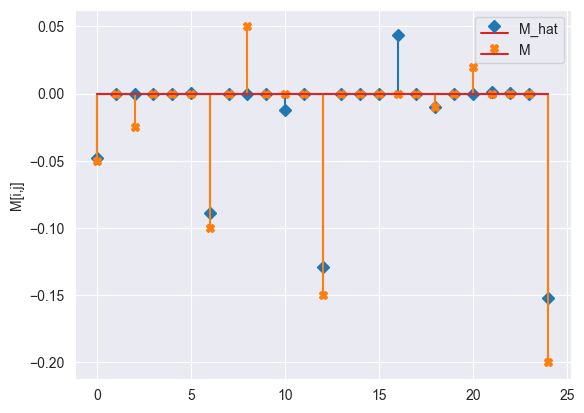

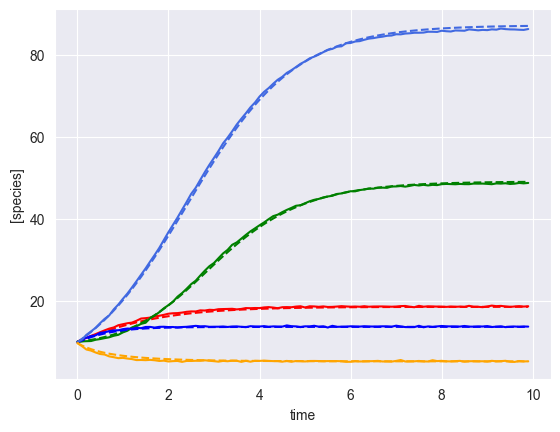

In [24]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

# read in the data
num_timecourses = 1
data = pd.read_csv("data-s5-r1.csv")
times = data.iloc[:, 0].values


# Define priors
prior_mu_mean = [1.0] 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage()



#nX = num_species
#n_obs = times.shape[0] - 1
#noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
#DA = nX*nX - nX
#DA0 = 3     # expected number of non zero entries in M_ij
#N = n_obs - 2

#inference = infergLVbayes(X, F, mu_prior, M_prior, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev)
#idata = inference.run_bayes_gLV_shrinkage()

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

# get median mu_hat and M_hat 
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )

# compare fitted with simulated parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)

### Bayesian inference with shrinkage and a perturbation with unknown interactions
Now we will do inference with the Horseshoe prior for shrinkage but now we include a perturbation (assuming unknown interaction terms). This gives more identifiability

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, epsilon_hat, M_ii_hat_p, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in sca

                    mean     sd  r_hat
mu_hat[0, 0]       1.231  0.132   1.00
mu_hat[0, 1]       0.588  0.129   1.00
mu_hat[0, 2]       1.677  0.128   1.00
mu_hat[0, 3]       0.879  0.128   1.00
mu_hat[0, 4]       0.854  0.016   1.00
...                  ...    ...    ...
epsilon_hat[0, 1] -0.897  0.028   1.01
epsilon_hat[0, 2]  0.849  0.029   1.00
epsilon_hat[0, 3] -0.882  0.028   1.00
epsilon_hat[0, 4]  0.906  0.028   1.00
sigma[0]           0.116  0.002   1.01

[61 rows x 3 columns]
(5, 1)
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.22634475, 0.58720846, 1.67252049, 0.88191289, 0.85426386]), 'M': array([[-4.79634847e-02,  2.04001530e-03, -2.24490360e-02,
        -1.34203370e-03,  2.26316874e-04],
       [ 8.77586982e-05, -9.07662849e-02, -6.63653574e-03,
         4.50412663e-02,  7.21577673e-03],
       [ 1.18454944e-03, -1.45917516e-03, -1.27749035e-01,
         1.34296594e-03,  4.05619023e-03],
       [-1.43392693e-03,  2.56506500e-03, -1.9

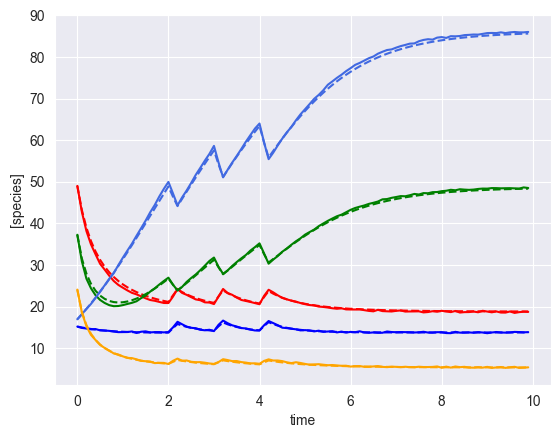

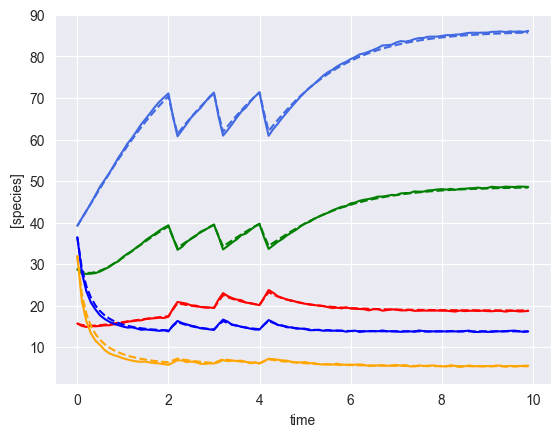

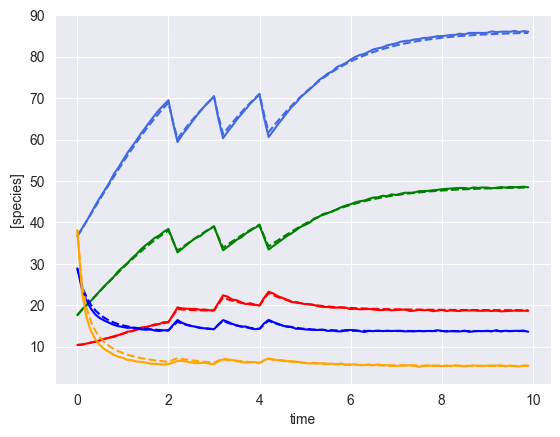

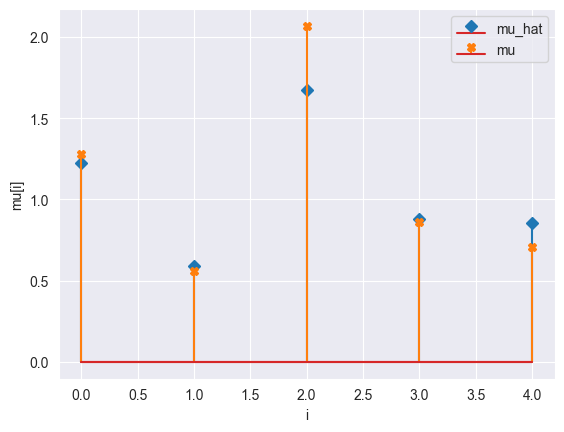

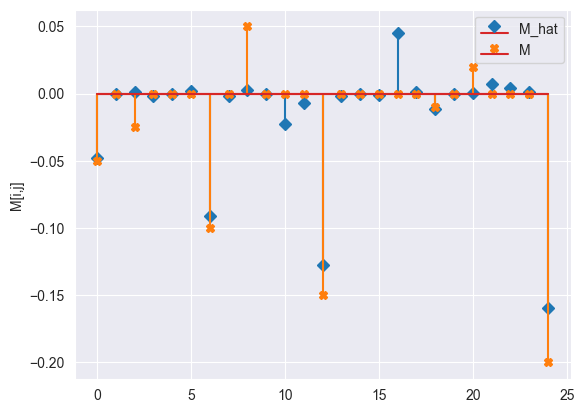

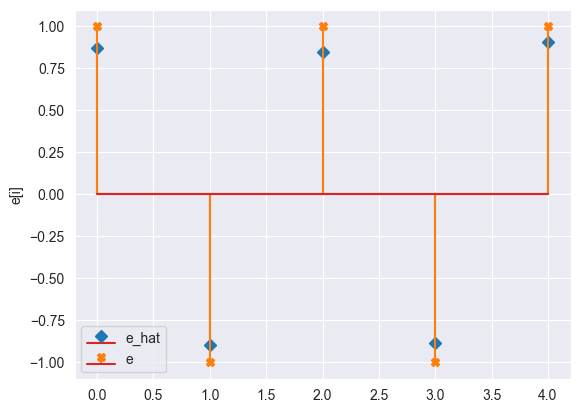

In [25]:
num_timecourses = 3
num_perturbations = 1
data = pd.read_csv("data-s5-r3-p1.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])

# create the perturbation signal
def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

u = np.array([pert_fn(t)[0] for t in times])
u = u.astype(int)

X = np.array([], dtype=np.double).reshape(0, num_species+2)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S_u(ryobs[timecourse_idx], times, u)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])


# Define priors
prior_mu_mean = [1.0] 
prior_mu_sigma = 0.5

## NB prior_Mii_mean is 0, so not defined as an argument
prior_Mii_mean =  0.0
prior_Mii_sigma = 0.1

prior_Mij_sigma = 0.1

prior_eps_mean = 0.1
prior_eps_sigma = 0.1

# Define parameters for shrinkage on M_ij (non diagonal elements)
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1

DA = nX*nX - nX

DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

# Run inference

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          prior_eps_mean=prior_eps_mean, prior_eps_sigma=prior_eps_sigma,
                          DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference_shrinkage_pert()



#nX = num_species
#n_obs = times.shape[0] - 1
#noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
#DA = nX*nX - nX
#DA0 = 3     # expected number of non zero entries in M_ij
#N = n_obs - 2

#inference = infergLVbayes(X, F, mu_prior, M_prior, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev, epsilon=epsilon)
#idata = inference.run_bayes_gLV_shrinkage_pert()

# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "epsilon_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]


# get median mu_hat and M_hat
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )
e_h = np.median(idata.posterior["epsilon_hat"].values, axis=(0,1) ).T

print(e_h.shape)

predictor = sim_gLV(num_species=num_species,
                    num_perturbations=1,
                    M=M_h.T,
                    mu=mu_h,
                    epsilon=e_h,
                    )

# # plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:], u=pert_fn)
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)

compare_params(mu=(mu, mu_h), M=(M, M_h), e=(epsilon, e_h))
